In [ ]:
!pip install "sb3_contrib>=2.0.0a1" --upgrade
!pip install "stable_baselines3>=2.0.0a1" --upgrade
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.9/182.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 72.3 MB/s eta 0:00:00


## Please following the instructions and **DO NOT** modify the example file in the shared drive! Download the folder "BEAR" and upload it to **your Drive** in "My Drive", then run the cells

In [61]:
import os
cwd = "D:\RL\HVAC\BEAR-main"
print(f"当前工作目录: {cwd}")
os.chdir(cwd)

当前工作目录: D:\RL\HVAC\BEAR-main


In [1]:
from Env.env_building import BuildingEnvReal
from Controller.MPC_Controller import MPCAgent
from Controller.DataCenterEnergyController import DataCenterEnergyController
from Utils.utils_building import ParameterGenerator, get_user_input
import numpy as np
import functools
import datetime
import os
import time
from collections import deque
import matplotlib.pyplot as plt

# 新段落

##Test

We start by creating an environment with a OfficeSmall type building at Tucson, and setting the weather type as Hot Dry:
在tucson创建一个包含OfficeSmall类型建筑的环境，并将天气类型设置为hot dry：

In [67]:
env = get_user_input()
numofhours=24
#Initialize
env.reset()
for i in range(numofhours):
    a = env.action_space.sample()#Randomly select an action
    obs, r, terminated, truncated, _ = env.step(a)#Return observation and reward
RandomController_state=env.statelist #Collect the state list
RandomController_action=env.actionlist #Collect the action list
env._get_info()

###############All Zones from Ground############
CORE_ZN  [Zone index]:  0
PERIMETER_ZN_1  [Zone index]:  1
PERIMETER_ZN_2  [Zone index]:  2
PERIMETER_ZN_3  [Zone index]:  3
PERIMETER_ZN_4  [Zone index]:  4
ATTIC  [Zone index]:  5
###################################################
How would you like to modify the reward function?
Enter 1 to use the default reward function.
Enter 2 to customize weights of the default function.
Enter 3 to fully customize the reward function.

Congratulations! You have successfully created an environment.


{'zone_temperature': array([ 8.30378469, 18.18694525, 20.54661997,  4.41984676, 13.57427662,
         7.9693224 ]),
 'reward_breakdown': {'comfort_level': -698.4521181272621,
  'power_consumption': -0.8298542804718018}}

In [37]:
RandomController_action[0]

array([ 2930.5967,  6115.695 ,  2971.3228, -7234.8037, -5289.5884,
       -4595.6616], dtype=float32)

With the new version updated, users can also customize the reward function now. A custom reward function is a function you define that takes the current state, the action, and the error (difference between target and actual temperature), and the new state as inputs, and returns a reward value. This reward value is used to guide the agent's learning.The function should be written on **reward_functions.py** in the folder **BEAR/Customize**. A sample reward function is shown here:
可以自定义奖励函数。自定义奖励函数是由您定义的函数，其输入包括当前状态、动作、误差（目标温度与实际温度的差值）以及新状态，并返回奖励值。该奖励值用于引导智能体的学习过程。该函数应编写在BEAR/Customize文件夹中的reward_functions.py文件内。示例奖励函数如下所示：

In [3]:
def my_custom_reward_function(self, state, action, error, state_new):
    # This is your default reward function
    # Initialize the reward
    reward = 0
    self.co2_rate=0.01
    self.temp_rate=0.01

    # Desired temperature range
    lower_temp = 18
    upper_temp = 22

    # Calculate the contribution of action to the reward
    action_contribution = LA.norm(action, 2) * self.q_rate
    reward -= action_contribution

    # Calculate the contribution of error to the reward
    error_contribution = LA.norm(error, 2) * self.error_rate
    reward -= error_contribution

    # Calculate the contribution of temperature deviation to the reward
    temp_deviation = np.sum(np.maximum(0, state_new - upper_temp) + np.maximum(0, lower_temp - state_new)) * self.temp_rate
    reward -= temp_deviation

    # Calculate the contribution of CO2 emissions to the reward
    co2_emission = LA.norm(action, 2) * self.co2_rate
    reward -= co2_emission

    self._reward_breakdown['action_contribution'] -= action_contribution
    self._reward_breakdown['error_contribution'] -= error_contribution
    self._reward_breakdown['temp_deviation'] -= temp_deviation
    self._reward_breakdown['co2_emission'] -= co2_emission
    return reward

For more advance users, you can directly modify the ParameterGenerator and BuildingEnvReal to customize your enviornment:
可以直接修改ParameterGenerator和BuildingEnvReal来定制环境：

In [4]:
Parameter=ParameterGenerator('OfficeSmall','Hot_Dry','Tucson')  #Description of ParameterGenerator in bldg_utils.py
#Create environment
env = BuildingEnvReal(Parameter)
numofhours=24
#Initialize with user-defined indoor temperature
env.reset(options={'T_initial':np.array([18.24489859, 18.58710076, 18.47719682, 19.11476084, 19.59438163,15.39221207])})
for i in range(numofhours):
    a = env.action_space.sample()#Randomly select an action
    obs, r, terminated, truncated, _ = env.step(a)#Return observation and reward
RandomController_state=env.statelist #Collect the state list
RandomController_action=env.actionlist #Collect the action list
env._get_info()

###############All Zones from Ground############
CORE_ZN  [Zone index]:  0
PERIMETER_ZN_1  [Zone index]:  1
PERIMETER_ZN_2  [Zone index]:  2
PERIMETER_ZN_3  [Zone index]:  3
PERIMETER_ZN_4  [Zone index]:  4
ATTIC  [Zone index]:  5
###################################################


{'zone_temperature': array([28.72059647, 35.01733585, 34.6960897 , 23.25753559, 34.0687662 ,
        30.57276488]),
 'reward_breakdown': {'comfort_level': -544.4430958615196,
  'power_consumption': -0.7983934450149538}}

The state space:$$s_k=[T_1[k],T_2[k], ...,T_{M}[k],Q_p[k],T_G[k],T_{E}[k],Q_{ghi}[k]]$$

The action space:$$a_k=[Q^z_{1}[k],Q^z_{2}[k],...,Q^z_{M}[k]]$$

In [5]:
obs_dim = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(obs_dim))
action_dim = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(action_dim))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))
print('Sample State :', RandomController_state[0])
print('Sample Action :', RandomController_action[0])

Size of State Space ->  20
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0
Sample State : [18.24489859 18.58710076 18.47719682 19.11476084 19.59438163 15.39221207
  5.6         0.          0.          0.          0.          0.
  0.         20.9        -0.03714446 -0.03714446 -0.03714446 -0.03714446
 -0.03714446 -0.03714446]
Sample Action : [-6143.96   -4147.5337 -2792.8225 -5773.4907  3126.5273 -4635.9976]


###No Action

We first test the environment with no actions. Let's loop for 24 hours and plot the temperature and energy comsumption of each zones :
首先在不采取任何行动的情况下测试环境。让我们循环运行24小时，并绘制每个区域的温度和能耗曲线：

In [6]:
obs

array([28.72059647, 35.01733585, 34.6960897 , 23.25753559, 34.0687662 ,
       30.57276488,  4.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 20.9       , -0.08277057,
       -0.08277057, -0.08277057, -0.08277057, -0.08277057, -0.08277057])

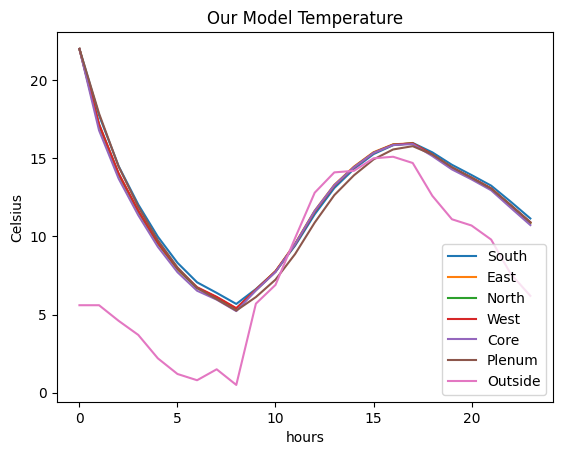

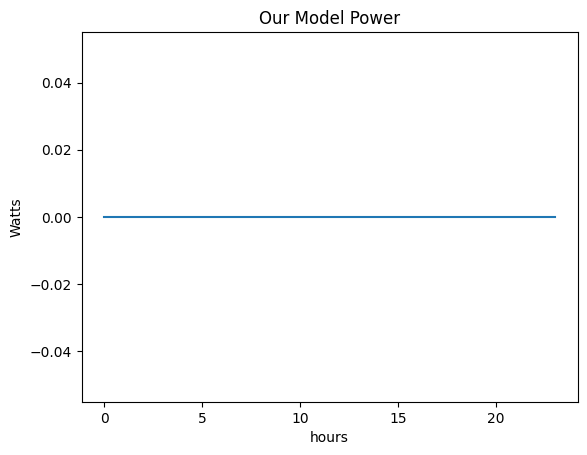

In [7]:

numofhours=24
env.reset()
a=env.action_space.sample()
for i in range(numofhours):

    a = [0,0,0,0,0,0]
    obs, r, terminated, truncated, _ = env.step(a)
plt.plot(np.array(env.statelist)[:,:7])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')

plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))

plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()

In [8]:
print('zone temerature at 1 a.m. :', np.array(env.statelist)[1,:6])

zone temerature at 1 a.m. : [17.75179317 17.07085633 17.14668666 17.19433022 16.78964807 17.86825243]


###MPC控制器

Then we use a MPC controller and set each room at 22 degrees:
然后我们使用MPC控制器，将每个房间的温度设定为22度：

total reward is:  -0.19466647171188572


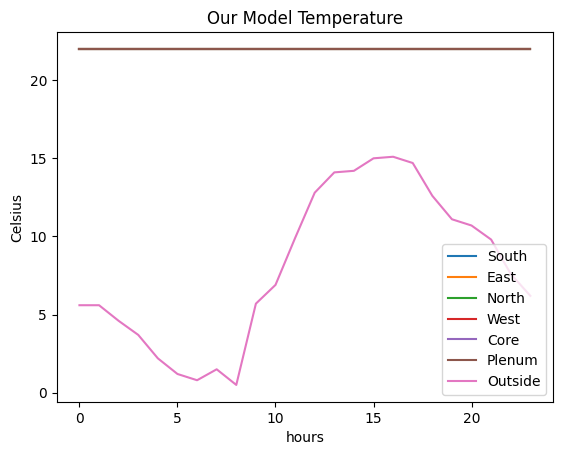

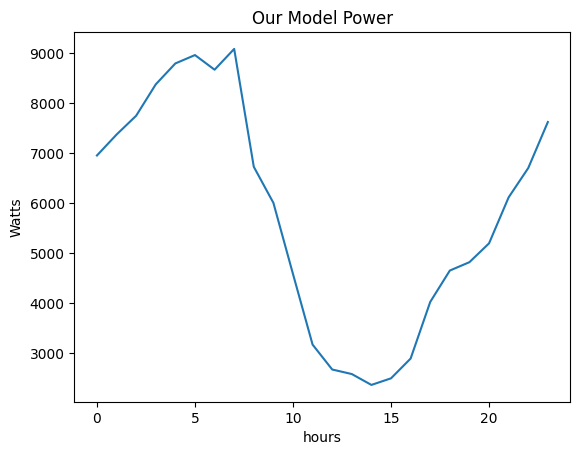

In [9]:
agent = MPCAgent(env,
                gamma=env.gamma,
                safety_margin=0.96, planning_steps=10)
env.reset()
numofhours=24
reward_total=0
for i in range(numofhours):
    a,s = agent.predict(env)
    obs, r, terminated, truncated, _ = env.step(a)
    reward_total+=r
print('total reward is: ',reward_total)
plt.plot(np.array(env.statelist)[:,:7])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()
MPCstate=env.statelist
MPCaction=env.actionlist

### 机房空调节能控制器（基于PDF算法）


开始使用机房空调节能控制器进行24小时控制...
算法特点：
1. 基于温度传感器的空调开关控制策略
2. 测温点敏感度分析与影响力计算
3. 区间群控节能优化
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
第6小时 - 节能效果: 0.0%, 平均能耗: 0.00
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
第12小时 - 节能效果: 100.0%, 平均能耗: 0.00
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
第18小时 - 节能效果: 100.0%, 平均能耗: 0.00
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
MPC优化失败: infeasible
第24小时 - 节能效果: 100.0%, 平均能耗: 0.00
total reward is:  -613.3678214549689

=== 机房空调节能控制器性能统计 ===
总节能效果: 100.0%
平均能耗: 0.00
平均温度: 12.1°C
平均占用率: 120.0
温度控制区间: [21.0, 23.0]°C
影响力矩阵已更新: True

=== 影响力分析 ===
制冷量配置: [1. 1. 1. 1. 1. 1.]
运行时间历史: [24. 24. 24. 24. 24. 24.]


C:\Users\小米\AppData\Local\Temp\ipykernel_37008\613183163.py:66: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\小米\AppData\Local\Temp\ipykernel_37008\613183163.py:66: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\小米\AppData\Local\Temp\ipykernel_37008\613183163.py:66: UserWarning: Glyph 31354 (\N{CJK UNIFIED IDEOGRAPH-7A7A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\小米\AppData\Local\Temp\ipykernel_37008\613183163.py:66: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\小米\AppData\Local\Temp\ipykernel_37008\613183163.py:66: UserWarning: Glyph 33410 (\N{CJK UNIFIED IDEOGRAPH-8282}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\小米\AppData\Local\Temp\ipykernel_37008\613183163.py:66: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-

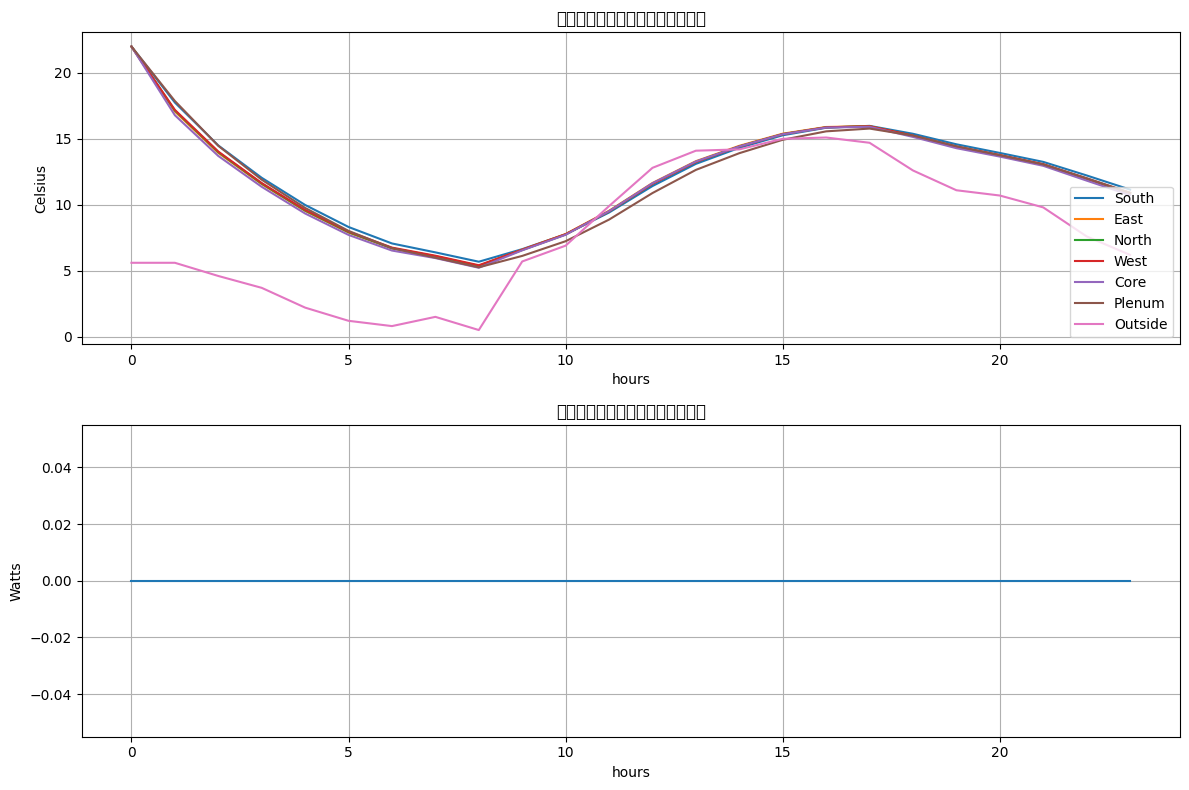

In [11]:
# 使用机房空调节能控制器（基于PDF中的算法）
# 这个控制器实现了区间群控节能策略
agent = DataCenterEnergyController(env,
                                 gamma=env.gamma,
                                 safety_margin=0.96, 
                                 planning_steps=10,
                                 alpha=0.1,  # 距离经验参数
                                 beta=0.05,  # 空调运行时间经验参数
                                 temp_tolerance=1.0)  # 温度容忍度

env.reset()
numofhours=24
reward_total=0

print("开始使用机房空调节能控制器进行24小时控制...")
print("算法特点：")
print("1. 基于温度传感器的空调开关控制策略")
print("2. 测温点敏感度分析与影响力计算")
print("3. 区间群控节能优化")

for i in range(numofhours):
    a,s = agent.predict(env)
    obs, r, terminated, truncated, _ = env.step(a)
    reward_total+=r
    
    # 每6小时显示一次控制统计信息
    if (i+1) % 6 == 0:
        stats = agent.get_control_statistics()
        print(f"第{i+1}小时 - 节能效果: {stats['energy_savings']:.1f}%, 平均能耗: {stats['avg_energy']:.2f}")

print('total reward is: ',reward_total)

# 显示最终控制统计信息
final_stats = agent.get_control_statistics()
print(f"\n=== 机房空调节能控制器性能统计 ===")
print(f"总节能效果: {final_stats['energy_savings']:.1f}%")
print(f"平均能耗: {final_stats['avg_energy']:.2f}")
print(f"平均温度: {final_stats['avg_temp']:.1f}°C")
print(f"平均占用率: {final_stats['avg_occupancy']:.1f}")
print(f"温度控制区间: [{final_stats['temp_range'][0]:.1f}, {final_stats['temp_range'][1]:.1f}]°C")
print(f"影响力矩阵已更新: {final_stats['influence_matrix_updated']}")

# 获取影响力分析
influence_analysis = agent.get_influence_analysis()
print(f"\n=== 影响力分析 ===")
print(f"制冷量配置: {influence_analysis['cooling_capacity']}")
print(f"运行时间历史: {influence_analysis['runtime_history']}")

# 绘制温度曲线
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(np.array(env.statelist)[:,:7])
plt.title('机房空调节能控制器温度控制效果')
plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.grid(True)

# 绘制能耗曲线
plt.subplot(2, 1, 2)
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('机房空调节能控制器能耗控制效果')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.grid(True)
plt.tight_layout()
plt.show()

# 保存结果用于比较
DataCenter_state=env.statelist
DataCenter_action=env.actionlist


### 两种控制器对比分析


In [12]:
# 对比分析：传统MPC vs 机房空调节能控制器
print("=== 两种控制器特性对比 ===")
print("\n1. 传统MPC控制器：")
print("   - 基于模型预测控制")
print("   - 优化目标：温度跟踪 + 能耗控制")
print("   - 特点：稳定可靠，但节能效果有限")

print("\n2. 机房空调节能控制器（DataCenterEnergyController）：")
print("   - 基于PDF算法的区间群控节能")
print("   - 测温点敏感度分析与影响力计算")
print("   - 基于温度传感器的空调开关控制策略")
print("   - 特点：专门针对机房环境优化")

# 性能对比（如果有数据的话）
controllers_data = {}

if 'MPCaction' in locals():
    controllers_data['MPC'] = {
        'energy': np.sum(np.abs(MPCaction)),
        'name': '传统MPC'
    }

if 'DataCenter_action' in locals():
    controllers_data['DataCenter'] = {
        'energy': np.sum(np.abs(DataCenter_action)),
        'name': '机房空调节能控制器'
    }

if len(controllers_data) > 1:
    print(f"\n=== 能耗对比分析 ===")
    baseline_energy = None
    for key, data in controllers_data.items():
        if baseline_energy is None:
            baseline_energy = data['energy']
            print(f"{data['name']}: {data['energy']:.2f} (基准)")
        else:
            savings = (baseline_energy - data['energy']) / baseline_energy * 100
            print(f"{data['name']}: {data['energy']:.2f} (节能 {savings:.1f}%)")

print(f"\n=== 推荐使用场景 ===")
print("• 传统MPC：适用于对稳定性要求高的场景")
print("• 机房空调节能控制器：专门适用于机房、数据中心等需要精确温度控制的场景")

print(f"\n=== 算法优势总结 ===")
print("机房空调节能控制器的优势：")
print("1. 基于实际机房环境特点设计")
print("2. 考虑空调与测温点的距离影响")
print("3. 实现区间群控，避免过度调节")
print("4. 结合温度传感器实时反馈")
print("5. 专门针对机房节能优化")


=== 两种控制器特性对比 ===

1. 传统MPC控制器：
   - 基于模型预测控制
   - 优化目标：温度跟踪 + 能耗控制
   - 特点：稳定可靠，但节能效果有限

2. 机房空调节能控制器（DataCenterEnergyController）：
   - 基于PDF算法的区间群控节能
   - 测温点敏感度分析与影响力计算
   - 基于温度传感器的空调开关控制策略
   - 特点：专门针对机房环境优化

=== 能耗对比分析 ===
传统MPC: 138623.46 (基准)
机房空调节能控制器: 0.00 (节能 100.0%)

=== 推荐使用场景 ===
• 传统MPC：适用于对稳定性要求高的场景
• 机房空调节能控制器：专门适用于机房、数据中心等需要精确温度控制的场景

=== 算法优势总结 ===
机房空调节能控制器的优势：
1. 基于实际机房环境特点设计
2. 考虑空调与测温点的距离影响
3. 实现区间群控，避免过度调节
4. 结合温度传感器实时反馈
5. 专门针对机房节能优化


In [13]:
print('zone temerature:', np.array(env.statelist)[0,:6])

zone temerature: [22. 22. 22. 22. 22. 22.]


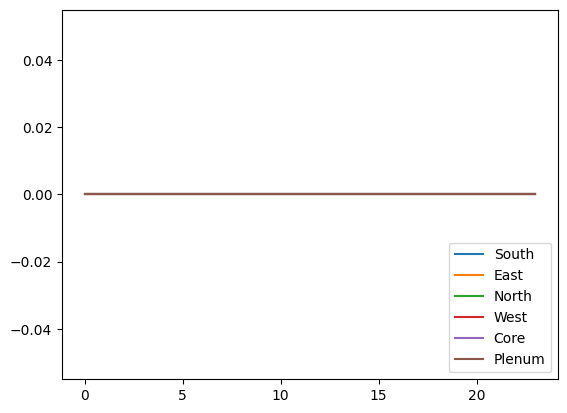

In [14]:
plt.plot(np.array(env.actionlist))
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
#plt.ylim([0,50])
plt.show()

### Reinforcement Learning

Finally, we use a PPO controller to demonstrate RL usage. We perform a quick train with default settings and save the model:
最后，我们使用PPO控制器来演示强化学习的应用。我们采用默认设置进行快速训练并保存模型：

In [30]:
from stable_baselines3 import PPO ,DQN,DDPG
from stable_baselines3.common.logger import configure
from stable_baselines3.ppo import MlpPolicy
# from stable_baselines.bench import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_vec_env

In [31]:

seed=0
env.reset()
set_random_seed(seed=seed)
model = PPO(MlpPolicy, env, verbose=1)
rewardlist=[]
action_record=[]

for i in range(100):
  model.learn(total_timesteps=1000)
  rw=0
  vec_env = model.get_env()
  obs = vec_env.reset()
  for i in range(24):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    rw+=rewards
  print(rw/24)
  rewardlist.append(rw/24)
  action_record.append(np.array(env.actionlist).sum(axis=1))
print("################TRAINING is Done############")
model.save("PPO_quick")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 248  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
[-27.05362]
-----------------------------
| time/              |      |
|    fps             | 261  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
[-26.196512]
-----------------------------
| time/              |      |
|    fps             | 302  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
[-27.264563]
-----------------------------
| time/              |      |
|    fps             | 232  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
[-30.548302]
---------------

Then, we load the model and see the performance of the state and action:
然后，我们加载模型并观察状态和动作的表现：

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Initial observation [[22.         22.         22.         22.         22.         22.
   5.6         0.          0.          0.          0.          0.
   0.         20.9        -0.07856952 -0.07856952 -0.07856952 -0.07856952
  -0.07856952 -0.07856952]]


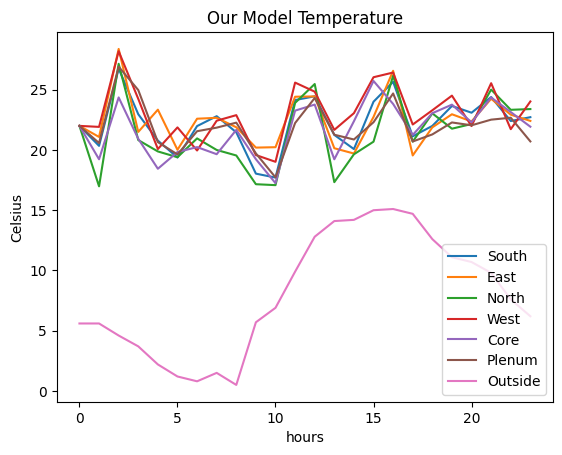

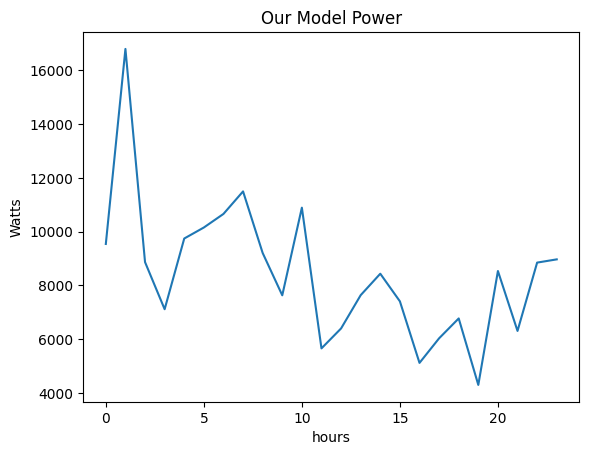

In [32]:

model = PPO(MlpPolicy, env, verbose=1)
vec_env = model.get_env()
model = PPO.load("PPO_quick")
obs = vec_env.reset()
print("Initial observation", obs)

for i in range(24):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
plt.plot(np.array(env.statelist)[:,:7])
plt.title('Our Model Temperature')

plt.xlabel('hours')
plt.ylabel('Celsius')
plt.legend(['South','East','North','West','Core','Plenum','Outside'],loc='lower right')
plt.show()
plt.plot(np.sum(np.abs(np.array(env.actionlist)),1))
plt.title('Our Model Power')
plt.xlabel('hours')
plt.ylabel('Watts')
plt.show()

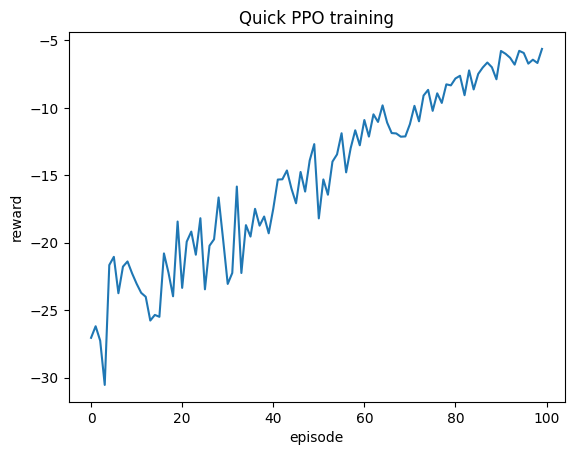

In [33]:
plt.title('Quick PPO training')
plt.plot(rewardlist)
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()

In [34]:
env.close()